## Read Data

Notebook to read in JSON data, filter to the goals and the passes in the build up and output a file for each league

In [1]:
import json
import os
import matplotlib.pyplot as plt


In [2]:
teams_dict = {}
with open("../Data/meta/teams.json") as f:
        teams = json.load(f)
        for team in teams:
            if team['type'] == 'club':
                teams_dict[team['wyId']] = team['name']


In [3]:
players_pos_dict = {}
with open("../Data/meta/players.json") as f:
    players = json.load(f)
    for p in players:
        players_pos_dict[p['wyId']] = p['role']['code2']



In [4]:
def createMatchesDict(country):
    """
        For a given country's leagues, create a dictionary of match data
        Keys should include the teams, line up and substitutions
    """
    matchesDict = {}
    playerOrder = ['GK', 'DF', 'MD', 'FW']
    order = {key: i for i, key in enumerate(playerOrder)}
    
    with open(f"../Data/matches/matches_{country}.json") as f:
        matches = json.load(f)
        for m in matches:
            teams = list(m['teamsData'].keys())
            matchesDict[m['wyId']] = []
            matchesDict[m['wyId']].append(list(m['teamsData'].keys()))
            temp_dict = {}
            for team in teams:
                temp_dict[team] = {}
                for player in m['teamsData'][team]['formation']['lineup']:
                    temp_dict[team][player['playerId']] = players_pos_dict[player['playerId']]
                temp_dict[team] = dict(sorted(temp_dict[team].items(), key=lambda item: order[item[1]]))
                ind = 0
                for t in temp_dict[team]:
                    temp_dict[team][t] = [temp_dict[team][t], ind]
                    ind += 1
                for subs in m['teamsData'][team]['formation']['substitutions']:
                    try:
                        temp_dict[team][subs['playerIn']] =  temp_dict[team][subs['playerOut']]
                    except:
                        continue
            matchesDict[m['wyId']].append(temp_dict)
            
    return matchesDict


In [5]:
# Define each of the 18 regions

regionsDict = {}

regionsDict[1] = [16.5, 1800/61]
regionsDict[2] = [16.5, 4300/61]
regionsDict[3] = [16.5, 100]
regionsDict[4] = [33.25, 1800/61]
regionsDict[5] = [33.25, 4300/61]
regionsDict[6] = [33.25, 100]
regionsDict[7] = [50, 1800/61]
regionsDict[8] = [50, 4300/61]
regionsDict[9] = [50, 100]
regionsDict[10] = [66.75, 1800/61]
regionsDict[11] = [66.75, 4300/61]
regionsDict[12] = [66.75, 100]
regionsDict[13] = [83.5, 1800/61]
regionsDict[14] = [83.5, 4300/61]
regionsDict[15] = [83.5, 100]
regionsDict[16] = [100, 1800/61]
regionsDict[17] = [100, 4300/61]
regionsDict[18] = [100, 100]


In [6]:
def createGoalsDict(country, matchesDict, writeToFile=False):
    """
        Given a country and matches dictionary for that country
        Read in the events data for that country
        And generate a goals dictionary
        Keys should include team, opposition, player who score, region and passes leading up to the goal
    """
    goals = {}
    e = 0
    with open(f"../Data/events/events_{country}.json") as f:
        events = json.load(f)
        while e < len(events):
            if {'id': 101} in events[e]['tags'] and events[e]['subEventId'] in [100, 91]:
                try:
                    team = events[e]['teamId']
                    if team not in goals:
                        goals[team] = []
                    tempDict = {}
                    tempDict['matchId'] = events[e]['matchId']
                    tempDict['teamId'] = team
                    tempDict['teamName'] = teams_dict[team]
                    tempDict['playerId'] = events[e]['playerId']
                    tempDict['position'] = events[e]['positions'][0]
                    for r in range(1, 19):
                        if (tempDict['position']['x'] <= regionsDict[r][0]) & (tempDict['position']['y'] <= regionsDict[r][1]):
                            tempDict['region'] = r
                            break
                    tempDict['playingPos'] = players_pos_dict[events[e]['playerId']]
                    if events[e]['teamId'] == int(matchesDict[events[e]['matchId']][0][0]):
                        tempDict['opponentId'] = matchesDict[events[e]['matchId']][0][1]
                    else:
                        tempDict['opponentId'] = matchesDict[events[e]['matchId']][0][0]
                    tempDict['oppenentName'] = teams_dict[int(tempDict['opponentId'])]
                    tempDict['playerIndex'] = matchesDict[events[e]['matchId']][1][str(team)][events[e]['playerId']][1]
                    tempDict['id'] = events[e]['id']
                    p_index = e-1
                    evnt = events[p_index]['eventName']
                    passes = []
                    tm = events[p_index]['teamId']
                    while (evnt == "Pass") & (tm == team):
                        pass_dict = {}
                        pass_dict['position'] = events[p_index]['positions'][0]
                        for r in range(1, 19):
                            if (pass_dict['position']['x'] <= regionsDict[r][0]) & (pass_dict['position']['y'] <= regionsDict[r][1]):
                                pass_dict['region'] = r
                                break
                        pass_dict['playerId'] = events[p_index]['playerId']
                        pass_dict['playingPos'] = players_pos_dict[events[p_index]['playerId']]
                        pass_dict['playerIndex'] = matchesDict[events[e]['matchId']][1][str(team)][pass_dict['playerId']][1]
                        p_index -= 1
                        evnt = events[p_index]['eventName']
                        tm = events[p_index]['teamId']
                        passes.append(pass_dict)
                    tempDict['passes'] = passes
                    goals[team].append(tempDict)
                    e += 1
                except:
                    print(f"Failed to add goal for match {events[e]['matchId']}")
                    e += 1
            e += 1
    if writeToFile == True:
        with open(f'../Data/output/goals_{country}.json', 'w') as f:
            json.dump(goals, f)
    return goals
                

In [7]:
matchesDict = createMatchesDict('England')
goalsEngland = createGoalsDict('England', matchesDict)


In [8]:
matchesDictSpain = createMatchesDict('Spain')
goalsSpain = createGoalsDict('Spain', matchesDictSpain)

Failed to add goal for match 2565904


In [9]:
matchesDictGermany = createMatchesDict('Germany')
goalsGermany = createGoalsDict('Germany', matchesDictGermany)

In [10]:
matchesDictFrance = createMatchesDict('France')
goalsFrance = createGoalsDict('France', matchesDictFrance)

In [11]:
matchesDictItaly = createMatchesDict('Italy')
goalsItaly = createGoalsDict('Italy', matchesDictItaly)

Failed to add goal for match 2576016


#### Validation

In order to validate, count the number of goals scored and check that it aligns with information on FB ref

In [12]:
goals_per_team_england = {}
for k, v in goalsEngland.items():
    passes = 0
    for goal in v:
        passes += len(goal['passes'])
    goals_per_team_england[k] = [len(v), passes/len(v)]

total_goals_england = 0
for team in goalsEngland:
    total_goals_england += len(goalsEngland[team])

total_goals_england

932

In [13]:
for k, v in goalsEngland.items():
    v = [x for x in v if len(x['passes']) >= 1]
    len_network = 0
    for g in v:
        len_network += len(g['passes'])
    goalsEngland[k] = v

total_goals_england = 0
for team in goalsEngland:
    total_goals_england += len(goalsEngland[team])

total_goals_england

408

In [14]:
goals_per_team_spain = {}
for k, v in goalsSpain.items():
    passes = 0
    for goal in v:
        passes += len(goal['passes'])
    goals_per_team_spain[k] = [len(v), passes/len(v)]

total_goals_spain = 0
for team in goalsSpain:
    total_goals_spain += len(goalsSpain[team])

total_goals_spain

907

In [15]:
for k, v in goalsSpain.items():
    v = [x for x in v if len(x['passes']) >= 1]
    len_network = 0
    for g in v:
        len_network += len(g['passes'])
    goalsSpain[k] = v

total_goals_spain = 0
for team in goalsSpain:
    total_goals_spain += len(goalsSpain[team])

total_goals_spain

414

In [16]:
goals_per_team_germany = {}
for k, v in goalsGermany.items():
    passes = 0
    for goal in v:
        passes += len(goal['passes'])
    goals_per_team_germany[k] = [len(v), passes/len(v)]

total_goals_germany = 0
for team in goalsGermany:
    total_goals_germany += len(goalsGermany[team])

total_goals_germany

765

In [17]:
for k, v in goalsGermany.items():
    v = [x for x in v if len(x['passes']) >= 1]
    len_network = 0
    for g in v:
        len_network += len(g['passes'])
    goalsGermany[k] = v

total_goals_germany = 0
for team in goalsGermany:
    total_goals_germany += len(goalsGermany[team])

total_goals_germany

341

In [18]:
goals_per_team_france = {}
for k, v in goalsFrance.items():
    passes = 0
    for goal in v:
        passes += len(goal['passes'])
    goals_per_team_france[k] = [len(v), passes/len(v)]

total_goals_france = 0
for team in goalsFrance:
    total_goals_france += len(goalsFrance[team])

total_goals_france

898

In [19]:
for k, v in goalsFrance.items():
    v = [x for x in v if len(x['passes']) >= 1]
    len_network = 0
    for g in v:
        len_network += len(g['passes'])
    goalsFrance[k] = v

total_goals_france = 0
for team in goalsFrance:
    total_goals_france += len(goalsFrance[team])

total_goals_france

392

In [20]:
goals_per_team_italy = {}
for k, v in goalsItaly.items():
    passes = 0
    for goal in v:
        passes += len(goal['passes'])
    goals_per_team_italy[k] = [len(v), passes/len(v)]

total_goals_italy = 0
for team in goalsItaly:
    total_goals_italy += len(goalsItaly[team])

total_goals_italy

889

In [21]:
for k, v in goalsItaly.items():
    v = [x for x in v if len(x['passes']) >= 1]
    len_network = 0
    for g in v:
        len_network += len(g['passes'])
    goalsItaly[k] = v

total_goals_italy = 0
for team in goalsItaly:
    total_goals_italy += len(goalsItaly[team])

total_goals_italy

393

To validate regions are defined correctly, plot on chart with each region being a different colour

In [24]:
x = []
y = []
r = []

for k,v in goalsItaly.items():
    for g in goalsItaly[k]:
        x.append(g['position']['x'])
        y.append(g['position']['y'])
        r.append(g['region'])
        for p in g['passes']:
            x.append(p['position']['x'])
            y.append(p['position']['y'])
            r.append(p['region'])

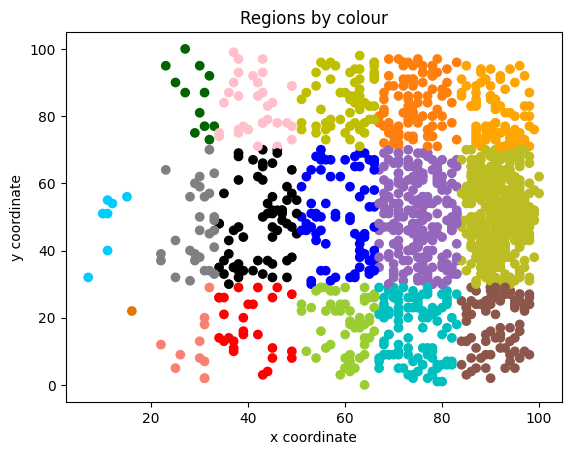

In [26]:
from matplotlib.colors import ListedColormap

colors = ['xkcd:pumpkin', "xkcd:bright sky blue", 'xkcd:light green', 
          'salmon', 'grey', 'darkgreen', 'red', 'black', 'pink', 'yellow'
        'green', 'b', 'y', 'c', 'tab:purple', 'tab:orange', 'tab:brown', 'tab:olive', 'orange']
cmap = ListedColormap(colors)
plt.scatter(x, y, c=r, cmap=cmap)
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Regions by colour')
plt.show()

In [ ]:
# Write data to files

with open('../Data/output/goals_England.json', 'w') as f:
    json.dump(goalsEngland, f)
with open('../Data/output/goals_France.json', 'w') as f:
    json.dump(goalsFrance, f)
with open('../Data/output/goals_Italy.json', 'w') as f:
    json.dump(goalsItaly, f)
with open('../Data/output/goals_Germany.json', 'w') as f:
    json.dump(goalsGermany, f)
with open('../Data/output/goals_Spain.json', 'w') as f:
    json.dump(goalsSpain, f)